In [1]:
# Stdlib
import sys
import os
import random

# Scientific computing
import numpy as np

# Network science
import networkx as nx

# Data handling and vis
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from node2vec import Node2Vec

# Project source
sys.path.append("../../src/")
from synthetic import *
from utils import *
import copy

# Functions

In [2]:
# ============= FUNCTIONS =================
def N2V(graph, parameters, hyperparameters):
    """Embed `graph` using node2vec.
    Parameters
    ----------
    graph : nx.Graph
        Graph to embed. Node and edge attributes are ignored.
    parameters : dict
        Keyword arguments for node2vec walk generation.
    hyperparameters : dict
        Keyword arguments for word2vec fitting on node2vec-generated walks.
    Returns
    -------
    dict
        Map of node ids to embedded vectors.
    """
    # Sample random walks
    embedding_model = Node2Vec(graph, **{k: v for k, v in parameters.items() if k in ["dimensions","walk_length","num_walks","workers","quiet"]})

    # Embed walks with word2vec and retrieve model
    embedding_model = embedding_model.fit()#**hyperparameters)
    embedding_model = embedding_model.wv

    # Retrieve resultant vectors
    vectors = embedding_model.vectors

    # Retrieve word2vec internal hash of node ids to vector indices
    node_labels = embedding_model.index_to_key

    # Map node ids into corresponding vector
    # This accounts for graphs with non-consecutive node ids
    embedding = {
        int(node_label): vectors[node_index]
        for node_index, node_label in enumerate(node_labels)
    }

    return embedding



def set_parameters_N2V(
    dimensions=128,
    walk_length=30,
    num_walks=100,
    workers=8,
    quiet=True,
    window=10,
    min_count=1,
    batch_words=4,
    penalty="l2",
    theta_min=0.05,
    theta_max=0.5,
    theta_num=10,
    repeat=5
        ):
    parameters = {
        # >>> Node2Vec embedding <<<
        "dimensions": dimensions,  # euclidean dimension to embedd
        "walk_length": walk_length,  # number of nodes in each walk
        "num_walks": num_walks,  # number of walks per node
        "workers": workers,  # for cpu parallel work
        "quiet": quiet,  # verbose printing
        # >>> Simulations <<<
        "theta_min": theta_min,
        "theta_max": theta_max,
        "theta_num": theta_num,
    }

    hyperparameters = {
        # >>> Node2Vec embedding <<<
        "window": window,  # maximum distance between the current and predicted word within a sentence.
        "min_count": min_count,  # ignores all words with total frequency lower than this
        "batch_words": batch_words,  # [unsure]

        # >>> Logistic regression <<<
        "penalty": penalty,  # L2 regularization

        # >>> Other <<<
        "repeat": repeat  # number of simulations
    }

    return parameters, hyperparameters


"""Project source code for applying Laplacian Eigenmap embedding.
"""
# ============= SET-UP =================
# --- Scientific computing ---
from scipy.sparse.linalg import eigsh  # eigensolver
from scipy.linalg import eigh

# --- Network science ---
import networkx as nx


# ============= FUNCTIONS =================
# --- Helpers ---
def _reindex_nodes(graph):
    reindexed_nodes = {
        index: new_index
        for new_index, index in enumerate(sorted(graph.nodes()))
    }  # Allow for non-contiguous node indices
    return reindexed_nodes


# --- Driver ---
def LE(graph, parameters, hyperparameters, dense_error=False):
    """Embed `graph` using Laplacian eigenmaps.
    Parameters
    ----------
    graph : nx.Graph
        Graph to embed. Node and edge attributes are ignored.
    parameters : dict
        Keyword arguments for LE parameter selection.
    hyperparameters : dict
        Keyword arguments for ARPACK convergence parameters.\
    dense_error : bool
        Indicator if graph is dense, i.e., k >= N, by default False.
    Returns
    -------
    ~~np.array~~
    dict
        Map of node ids to embedded vectors (as rows).
    """
    # >>> Book-keeping >>>
    reindexed_nodes = _reindex_nodes(graph)  # fix networkx indexing
    vectors = dict()
    # ! >>> BROKEN >>>
    # ! Non-contiguous indexing in some real remnants is causing
    # ! indexing errors with arrays - generalizing to a dict instead
    # ! All downstream analyses are able to proceed
    # vectors = np.zeros(
    #     (graph.number_of_nodes(), parameters["k"])  # needs k for scipy.sparse.linalg.eigsh
    # )  # initialize embedded vectors
    # ! <<< BROKEN <<<
    # <<< Book-keeping <<<

    # Calculate normalized Laplacian matrix
    L = nx.normalized_laplacian_matrix(graph, nodelist=sorted(graph.nodes()))

    # Compute the eigenspectra of the normalized Laplacian matrix
    # ! >>> BROKEN >>>
    #_, eigenvectors = \
    #    eigsh(L, **parameters, **hyperparameters)
    # ! <<< BROKEN <<<
    # ! >>> HOTFIX >>>
    if dense_error:
        _, eigenvectors = eigh(L.toarray())
    else:
        _, eigenvectors = \
            eigsh(
                L, k=parameters["k"],
                maxiter=hyperparameters["maxiter"],
                tol=hyperparameters["tol"],
                ncv=hyperparameters["NCV"]*graph.number_of_nodes()
            )
    # ! <<< HOTFIX <<<

    # Apply node reindexing (thanks networkx :/)
    for index, new_index in reindexed_nodes.items():
        vectors[index] = eigenvectors[new_index]

    return vectors


def LE_per_component(graph, parameters, hyperparameters, dense_error=False):
    # >>> Book-keeping >>>
    vectors_per_component = []  # list of vector embeddings, canonical ordering
    vectors = {}  # amalgamated mapping of nodes to their embedded vectors (by component)
    # <<< Book-keeping <<<

    # Retrieve each component as a graph
    component_subgraphs = [
        graph.subgraph(component).copy()
        for component in nx.connected_components(graph)
    ]

    # Embed each component by themselves
    for component_subgraph in component_subgraphs:
        vectors_per_component.append(
            LE(component_subgraph, parameters, hyperparameters, dense_error=dense_error)
        )

    # Amalgamate results
    for component_vectors in vectors_per_component:
        for node, vector in component_vectors.items():
            vectors[node] = vector

    return vectors

def set_parameters_LE(
    dimensions=128,
    maxiter=100,
    tol=-8,
    penalty="l2",
    theta_min=0.05,
    theta_max=0.5,
    theta_num=10,
    repeat=5
        ):
    parameters = {
        # >>> LE embedding <<<
        "k": dimensions,  # needs k for scipy.sparse.linalg.eigsh

        # >>> Simulations <<<
        "theta_min": theta_min,
        "theta_max": theta_max,
        "theta_num": theta_num,
    }

    hyperparameters = {
        # >>> LE embedding <<<
        "maxiter": maxiter,
        "tol": tol,
        "NCV": 6,

        # >>> Logistic regression <<<
        "penalty": penalty,  # L2 regularization

        # >>> Other <<<
        "repeat": repeat  # number of simulations
    }

    return parameters, hyperparameters

def format_system(params):
    # Process parameters
    pfi = params["pfi"]
    graphs = params["graphs"]
    left = params["left"]
    right = params["right"]

    # Form "raw" duplex
    multiplex = graphs

    # Split into layers
    G, H = duplex_network(multiplex, left, right)

    # Observe partial information
    R_G, R_H, testset = partial_information(G, H, pfi)

    # Restrict to largest connected component (if specified)
    if params["largest_component"]:
        R_G_ = nx.Graph()
        R_H_ = nx.Graph()
        R_G_.add_nodes_from(R_G.nodes())
        R_H_.add_nodes_from(R_H.nodes())

        maxcc_R_G = max(nx.connected_components(R_G), key=len)
        maxcc_R_H = max(nx.connected_components(R_H), key=len)

        edges_R_G_ = set(R_G.subgraph(maxcc_R_G).edges())
        edges_R_H_ = set(R_H.subgraph(maxcc_R_H).edges())
        R_G_.add_edges_from(edges_R_G_)
        R_H_.add_edges_from(edges_R_H_)

        testset = {
            edge: gt_
            for edge, gt_ in testset.items()
            if edge in edges_R_H_ | edges_R_H_
        }

    return G, H, R_G, R_H, testset


def reconstruct_system(testset, G, H, G_, H_, params):
    cls,scores,gt = [],[],[]

    for edge, gt_ in testset.items():
        i, j = edge
        gt.append(gt_)
        if params["metric"] == "logistic":
            d_G = np.linalg.norm(G_[i] - G_[j])
            d_H = np.linalg.norm(H_[i] - H_[j])
        t_G = d_G / (d_G + d_H)
        t_H = d_H / (d_G + d_H)
        scores.append(t_G)
        if t_G != t_H:
            if t_H > t_G:
                cls_ = 1
            elif t_H < t_G:
                cls_ = 0
            else:
                cls_=np.random.randint(2)
        cls.append(cls_)
    return cls, scores, gt




# London Analysis

In [3]:
path='/Users/siddharthpatwardhan/Downloads/Archived/MRP_Figures/Figure4/Data/multiplex_network-'
G=read_file(path+'london'+'.edgelist')

In [ ]:
pis=np.linspace(0,1,11)[:-1]
accs,aucs=[],[]
for pi in pis:
    aac,aau=[],[]
    for _ in range(2):
        _, _, R_G, R_H, testset=format_system({'pfi':pi,'graphs':G,'left':1,'right':2,'largest_component':False})
        test=list(testset.values())
        results=[]
        scores=[]
        BG,BH=nx.edge_betweenness_centrality(R_G),nx.edge_betweenness_centrality(R_H)
        for e in testset:
            try:
                bG,bH=BG[e],BH[e]
            except:
                bG,bH=BG[(e[1],e[0])],BH[(e[1],e[0])]
            if bG>bH:
                results.append(1)
                # scores.append(bG/(bG+bH))
            else:
                results.append(0)
                # scores.append(bH/(bG+bH))
        aac.append(accuracy_score(list(testset.values()),results))
        # aau.append(roc_auc_score(list(testset.values()),scores))
    accs.append(np.mean(aac))
    # aucs.append(np.mean(aau))

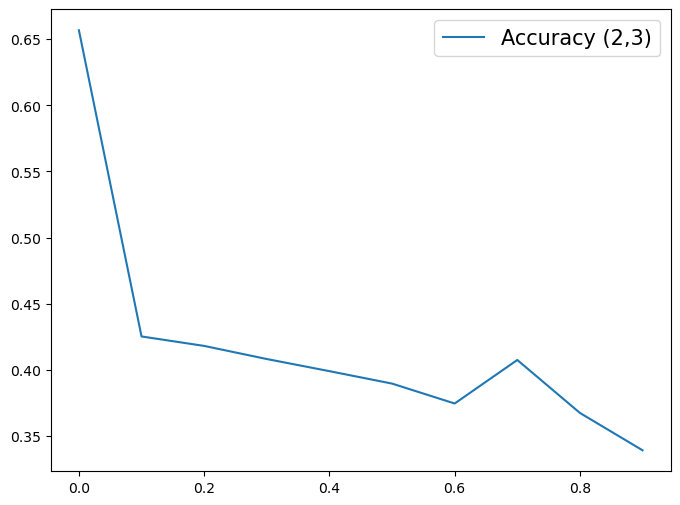

In [57]:
plt.figure(figsize=(8,6))
plt.plot(pis,accs,label='Accuracy (2,3)')
# plt.plot(pis,aucs,label='ROC AUC (2,3)')
plt.legend(fontsize=15)

In [5]:
_, _, R_G, R_H, testset=format_system({'pfi':0.3,'graphs':G,'left':2,'right':3,'largest_component':False})

In [33]:
test=list(testset.values())
between_results=[]
BG,BH=nx.edge_betweenness_centrality(R_G),nx.edge_betweenness_centrality(R_H)
for e in testset:
    try:
        bG=BG[e]
        bH=BH[e]
    except:
        bG=BG[(e[1],e[0])]
        bH=BH[(e[1],e[0])]
    if bG>bH:
        between_results.append(1)
    else:
        between_results.append(0)

In [34]:
accuracy_score(list(testset.values()),between_results)

0.9550561797752809

In [ ]:
pm,hm=set_parameters_N2V()
G_=N2V(R_G,pm,hm)
H_=N2V(R_H,pm,hm)

In [ ]:
[a,b,c]=reconstruct_system(testset, G, H, G_, H_, {'metric':'logistic'})

# Error Analysis

In [118]:
i,j=1,77
print(R_G.degree(i),R_G.degree(j),R_H.degree(i),R_H.degree(j))
print(np.linalg.norm(G_[i] - G_[j]),np.linalg.norm(H_[i] - H_[j]))

4 2 3 2
9.604995838089977e-05 3.454175966527893e-15


In [ ]:
testset

# Average Distance Scaling with Number of Edges

In [13]:
gs=[nx.grid_2d_graph(i,i,periodic=True) for i in range(5,20)]
gs=[nx.convert_node_labels_to_integers(gs[i]) for i in range(15)]
for i in range(15):
    gs[i].add_nodes_from(list(range(int(i*i),400)))

In [ ]:
avg_neighbor_distance=[]
for net in gs:
    avg=[]
    pm,hm=set_parameters_N2V(dimensions=128)
    e=N2V(net,pm,hm)
    for ed in net.edges():
        avg.append(np.linalg.norm(e[ed[0]] - e[ed[1]]))
    avg_neighbor_distance.append(np.mean(avg))

plt.plot([g.number_of_edges() for g in gs],[i for i in avg_neighbor_distance],'^--r')
plt.xlabel('Number of Edges',fontsize=15)
plt.ylabel('Average Distance (neighbors)',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [ ]:
plt.plot([g.number_of_edges() for g in gs],[i for i in avg_neighbor_distance],'^--r')
plt.xlabel('Number of Edges',fontsize=15)
plt.ylabel('Average Distance (neighbors)',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [ ]:
gs=[nx.gnm_random_graph(100,i) for i in range(200,400,20)]
gs=[nx.convert_node_labels_to_integers(gs[i]) for i in range(len(range(200,400,20)))]

avg_neighbor_distance=[]
for net in gs:
    avg=[]
    pm,hm=set_parameters_N2V(dimensions=128)
    e=N2V(net,pm,hm)
    for ed in net.edges():
        avg.append(np.linalg.norm(e[ed[0]] - e[ed[1]]))
    avg_neighbor_distance.append(np.mean(avg))

plt.plot([g.number_of_edges() for g in gs],[i for i in avg_neighbor_distance],'^--r')
plt.xlabel('Number of Edges',fontsize=15)
plt.ylabel('Average Distance (neighbors)',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

## SP Logistic Regression Exploration

In [3]:
# --- Scientific computing ---
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# ========== FUNCTIONS ==========
# --- Model training ---
def train_fit_logreg(X_train, y_train, seed=37):
    model = LogisticRegression(random_state=seed)
    model.fit(X_train, y_train)

    return model

def get_model_fit(model):
    return model.intercept_[0], model.coef_

# --- Reconstruction ---
def get_reconstruction(model, X_test):
    return model.predict(X_test)

def get_scores(model, X_test, class_label=1):
    # class_label = 1 indicates scoring for classification in G.
    return model.predict_proba(X_test)[:, class_label]

# --- Performance measures ---
def get_model_accuracy(model, X_test, y_test):
    return model.score(X_test, y_test)

def get_model_auroc(model, X_test, y_test):
    scores = get_scores(model, X_test)
    return roc_auc_score(y_test, scores)


# --- Helpers ---
def prepare_feature_matrix(
    distances_G, distances_H,
    degrees_i_G, degrees_i_H,
    degrees_j_G, degrees_j_H
):
    # >>> Book-keeping >>>
    NUM_FEATURES = 6  # number of features
    length = len(distances_G)  # number of observations in dataset
    feature_matrix = np.empty((length, NUM_FEATURES))  # initialize feature matrix
    # <<< Book-keeping <<<

    # >>> Format feature matrix >>>
    feature_matrix[:, 0] = distances_G
    feature_matrix[:, 1] = distances_H
    feature_matrix[:, 2] = degrees_i_G
    feature_matrix[:, 3] = degrees_i_H
    feature_matrix[:, 4] = degrees_j_G
    feature_matrix[:, 5] = degrees_j_H
    # <<< Format feature matrix <<<

    return feature_matrix

In [39]:
#create train and test for logreg
path='/Users/siddharthpatwardhan/Downloads/Archived/MRP_Figures/Figure4/Data/multiplex_network-'
G=read_file(path+'london'+'.edgelist')
g, h, R_G, R_H, testset=format_system({'pfi':0.3,'graphs':G,'left':1,'right':2,'largest_component':False})
EG=set(R_G.edges())
EH=set(R_H.edges())
EGL=list(R_G.edges())
EHL=list(R_H.edges())

trainset={(i,j):1 for (i,j) in EGL if (i,j) not in EH}
trainset.update({(i,j):0 for (i,j) in EHL if (i,j) not in EG})

pm,hm=set_parameters_N2V()
E1=N2V_per_component(R_G,pm,hm)
E2=N2V_per_component(R_H,pm,hm)

In [40]:
#F1
def degree_ratio(r1,r2,i,j,norm=True):
    try:
        r=(r1.degree(i)*r1.degree(j))/(r2.degree(i)*r2.degree(j))
    except:
        r=r1.degree(i)*r1.degree(j)/0.0001
    if norm:
        return 2*r-1
    else:
        return r

def degree_g1(r1,r2,i,j,norm=True):
    return r1.degree(i)
def degree_g2(r1,r2,i,j,norm=True):
    return r1.degree(j)
def degree_h1(r1,r2,i,j,norm=True):
    return r2.degree(i)
def degree_h2(r1,r2,i,j,norm=True):
    return r2.degree(j)



#F3
def dist_ratio(r1,r2,i,j,norm=True):
    r=np.linalg.norm(E1[i] - E1[j])/(np.linalg.norm(E2[i] - E2[j])+1e-6)
    if norm==True:
        return 2*r-1
    else:
        return r




norm=True

print('Model 1: combined degrees')
features=[degree_ratio,dist_ratio]
xtr,ytr=np.zeros((len(trainset),len(features))),np.zeros(len(trainset))
for n,e in enumerate(trainset):
    for f in range(len(features)):
        xtr[n][f]=features[f](R_G,R_H,e[0],e[1],norm=norm)
        ytr[n]=trainset[e]
# for f in range(len(features)):
#     m,s=np.mean(xtr[:,f]),np.std(xtr[:,f])
#     xtr[:,f]=np.asarray([(i-m)/s for i in xtr[:,f]])
xts,yts=np.zeros((len(testset),len(features))),np.zeros(len(testset))
for n,e in enumerate(testset):
    for f in range(len(features)):
        xts[n][f]=features[f](R_G,R_H,e[0],e[1],norm=norm)
        yts[n]=testset[e]
# for f in range(len(features)):
#     m,s=np.mean(xts[:,f]),np.std(xts[:,f])
#     xts[:,f]=np.asarray([(i-m)/s for i in xts[:,f]])
model=train_fit_logreg(xtr,ytr)
print('Model',get_model_fit(model))
print('Accuracy:',get_model_accuracy(model,xts,yts))
print('AUROC:',get_model_auroc(model,xts,yts))




Model 1: combined degrees
Model (0.0026401135925588895, array([[ 0.03717931, -0.00051635]]))
Accuracy: 0.8274509803921568
AUROC: 0.8704710144927535


/Users/siddharthpatwardhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
tr1=[x[0] for i,x in enumerate(xtr) if ytr[i]==0]
tr2=[x[0] for i,x in enumerate(xtr) if ytr[i]==1]

plt.hist(tr2)

In [87]:
def full_model_results(net='london',layers=[2,3],per_component=True):
    accs,aucs=[],[]
    #create train and test for logreg
    path='/Users/siddharthpatwardhan/Downloads/Archived/MRP_Figures/Figure4/Data/multiplex_network-'
    G=read_file(path+net+'.edgelist')
    pis=np.linspace(0.1,0.9,9)
    for pi in pis:    
        g, h, R_G, R_H, testset=format_system({'pfi':pi,'graphs':G,'left':layers[0],'right':layers[1],'largest_component':False})
        EG=set(R_G.edges())
        EH=set(R_H.edges())
        EGL=list(R_G.edges())
        EHL=list(R_H.edges())

        trainset={(i,j):1 for (i,j) in EGL if (i,j) not in EH}
        trainset.update({(i,j):0 for (i,j) in EHL if (i,j) not in EG})

        pm,hm=set_parameters_N2V()
        if per_component:
            E1=N2V_per_component(R_G,pm,hm)
            E2=N2V_per_component(R_H,pm,hm)
        else:
            E1=N2V(R_G,pm,hm)
            E2=N2V(R_H,pm,hm)
        # print('Model 1: combined degrees')
        features=['distance']
        xtr,ytr=np.zeros((len(trainset),len(features))),np.zeros(len(trainset))
        for n,e in enumerate(trainset):
            i,j=e[0],e[1]
            r=R_G.degree(i)*R_G.degree(j)/(R_H.degree(i)*R_H.degree(j)+0.001)
            d=np.linalg.norm(E1[i] - E1[j])/(np.linalg.norm(E2[i] - E2[j])+1e-6)
            xtr[n][0]=2*d-1
            # xtr[n][1]=2*d-1
            ytr[n]=trainset[e]

        xts,yts=np.zeros((len(testset),len(features))),np.zeros(len(testset))
        for n,e in enumerate(testset):
            i,j=e[0],e[1]
            r=R_G.degree(i)*R_G.degree(j)/(R_H.degree(i)*R_H.degree(j)+0.001)
            d=np.linalg.norm(E1[i] - E1[j])/(np.linalg.norm(E2[i] - E2[j])+1e-6)
            # xts[n][0]=2*r-1
            xts[n][0]=2*d-1
            yts[n]=testset[e]

        model=train_fit_logreg(xtr,ytr)
        print('Model',get_model_fit(model))
        print('Accuracy:',get_model_accuracy(model,xts,yts))
        print('AUROC:',get_model_auroc(model,xts,yts))
        aucs.append(get_model_auroc(model,xts,yts))
        accs.append(get_model_accuracy(model,xts,yts))
        
    return aucs,accs


        

Text(0.5, 1.0, 'London: Layers 1 and 2')

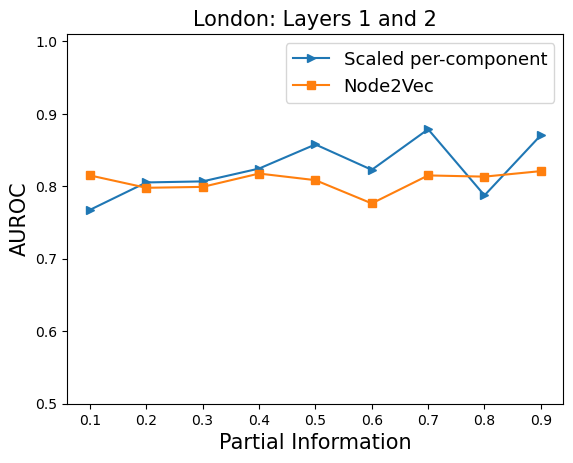

In [89]:


# AUC=np.zeros(9)
# ACC=np.zeros(9)
# for _ in range(2):
#     aucs,accs=full_model_results(layers=[1,2])
#     AUC=AUC+np.asarray(aucs)
#     ACC=ACC+np.asarray(accs)
# AUC=AUC/2
# ACC=ACC/2

# AUC_=np.zeros(9)
# ACC_=np.zeros(9)
# for _ in range(2):
#     aucs,accs=full_model_results(layers=[1,2],per_component=False)
#     AUC_=AUC_+np.asarray(aucs)
#     ACC_=ACC_+np.asarray(accs)
# AUC_=AUC_/2
# ACC_=ACC_/2

plt.plot(np.linspace(0.1,0.9,9),ACC,'>-',label='Scaled per-component')
plt.plot(np.linspace(0.1,0.9,9),ACC_,'s-',label='Node2Vec')

plt.ylim(0.5,1.01)
plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 1 and 2',fontsize=15)

Text(0.5, 1.0, 'London: Layers 2 and 3')

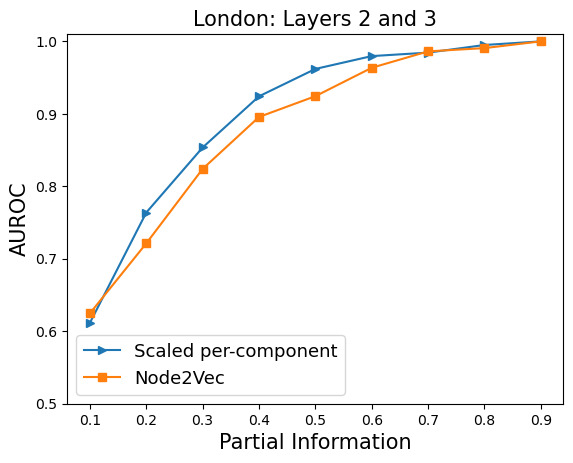

In [67]:
plt.plot(np.linspace(0.1,0.9,9),AUC,'>-',label='Scaled per-component')
plt.plot(np.linspace(0.1,0.9,9),AUC_,'s-',label='Node2Vec')

plt.ylim(0.5,1.01)
plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 2 and 3',fontsize=15)

# SP node2vec scaled per component

In [28]:

G=nx.erdos_renyi_graph(100,0.015)



In [102]:
'''
This function takes a graph, parameters and hyperparameters as input and returns a mapping of nodes to their embedded vectors.
The function performs the following steps:

1. Initializes two empty data structures: 
vectors_per_component and vectors
2. Retrieves each component as a graph and stores them in a list sorted by size in descending order
3. Embeds each component by themselves using the N2V function
4. Scales the results of each component by the average norm of the largest component
5. Amalgamates the results by mapping each node to its embedded vector
6. Finally, the function returns the mapping of nodes to their embedded vectors.

Thank ChatGPT for this! :D 
'''

def N2V_normalized_per_component(graph, parameters, hyperparameters):
    vectors_per_component = []  # list of vector embeddings, canonical ordering
    vectors = {}  # amalgamated mapping of nodes to their embedded vectors (by component)
    # Retrieve each component as a graph
    component_subgraphs = sorted([ graph.subgraph(component).copy() for component in nx.connected_components(graph)], key=len,reverse=True)
    # Embed each component by themselves
    for component_subgraph in component_subgraphs:
        vectors_per_component.append(N2V(component_subgraph, parameters, hyperparameters))
    #scale results
    average_norm_gcc=np.mean([np.linalg.norm(i) for i in vectors_per_component[0].values()])
    for n,component_subgraph in enumerate(vectors_per_component[1:]):
        average_norm_multiplier=average_norm_gcc/np.mean([np.linalg.norm(i) for i in component_subgraph.values()])
        for node in component_subgraph:
            component_subgraph[node]=average_norm_multiplier*(component_subgraph[node])
    # Amalgamate results
    for component_vectors in vectors_per_component:
        for node, vector in component_vectors.items():
            vectors[node] = vector
    return vectors

In [81]:
path='/Users/siddharthpatwardhan/Downloads/Archived/MRP_Figures/Figure4/Data/multiplex_network-'
G=read_file(path+'london'+'.edgelist')
g, h, R_G, R_H, testset=format_system({'pfi':0.5,'graphs':G,'left':1,'right':2,'largest_component':False})
EG=set(R_G.edges())
EH=set(R_H.edges())
EGL=list(R_G.edges())
EHL=list(R_H.edges())

pm,hm=set_parameters_N2V()
E1=N2V(R_H,pm,hm)
E2=N2V_per_component(R_H,pm,hm)

Model (2.777619147853626, array([[-0.92610388]]))
Accuracy: 0.6229508196721312
AUROC: 0.319693847512511
Model (1.3120776707889799, array([[-0.74976856]]))
Accuracy: 0.42574257425742573
AUROC: 0.29411764705882354


/Users/siddharthpatwardhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model (0.34282177128767133, array([[0.00128047]]))
Accuracy: 0.6707317073170732
AUROC: 0.896969696969697
Model (0.4699918560679636, array([[6.17014109e-06]]))
Accuracy: 0.6176470588235294
AUROC: 0.966117216117216


/Users/siddharthpatwardhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model (2.910484093465784e-10, array([[0.00045447]]))
Accuracy: 0.8153846153846154
AUROC: 0.9545454545454545
Model (0.36463633728764594, array([[6.79102291e-06]]))
Accuracy: 0.5227272727272727
AUROC: 1.0
Model (0.030437388151682856, array([[0.01723377]]))
Accuracy: 0.75
AUROC: 1.0


/Users/siddharthpatwardhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model (1.4844553244228132e-10, array([[0.00045379]]))
Accuracy: 0.7916666666666666
AUROC: 1.0
Model (-0.7419383010969511, array([[9.06683295e-06]]))
Accuracy: 0.23529411764705882
AUROC: 1.0
Model (3.7248630543968577, array([[-1.08904367]]))
Accuracy: 0.5739130434782609
AUROC: 0.30916282135794326
Model (0.8266633535389659, array([[4.53550734e-06]]))
Accuracy: 0.6285714285714286
AUROC: 0.7983682983682984
Model (4.004976720909377, array([[-1.48860889]]))
Accuracy: 0.425531914893617
AUROC: 0.2821659215101838
Model (0.5212850271617938, array([[6.50082615e-06]]))
Accuracy: 0.6197183098591549
AUROC: 0.9722222222222221


/Users/siddharthpatwardhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model (2.1049749155909694e-10, array([[0.00045446]]))
Accuracy: 0.890625
AUROC: 0.9384057971014492


/Users/siddharthpatwardhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model (2.2176404069318097e-10, array([[0.00045376]]))
Accuracy: 0.782608695652174
AUROC: 0.9865384615384616
Model (0.09218184791272732, array([[6.9712365e-06]]))
Accuracy: 0.65
AUROC: 0.9972527472527473


/Users/siddharthpatwardhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model (1.830359460227827e-10, array([[0.00045381]]))
Accuracy: 0.88
AUROC: 1.0


/Users/siddharthpatwardhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model (1.436766887173791e-10, array([[0.00045378]]))
Accuracy: 1.0
AUROC: 1.0
Model (1.8200627599725823, array([[-1.24509396]]))
Accuracy: 0.6228070175438597
AUROC: 0.2396723646723647
Model (1.0724862323151862, array([[-0.17998211]]))
Accuracy: 0.6476190476190476
AUROC: 0.1478537360890302
Model (0.9400861008443422, array([[-0.01390212]]))
Accuracy: 0.611764705882353
AUROC: 0.03787878787878787
Model (0.48681736441782236, array([[0.00288967]]))
Accuracy: 0.6578947368421053
AUROC: 0.9184615384615384
Model (0.7020349649273624, array([[-0.02921862]]))
Accuracy: 0.6486486486486487
AUROC: 0.023237179487179474
Model (0.4563199946405068, array([[0.01969053]]))
Accuracy: 0.6481481481481481
AUROC: 1.0
Model (0.20968971494022434, array([[0.04392867]]))
Accuracy: 0.6818181818181818
AUROC: 0.9952380952380953
Model (-0.4089770179589574, array([[0.10876113]]))
Accuracy: 0.52
AUROC: 0.9935897435897436
Model (-0.9711087330258202, array([[0.15309531]]))
Accuracy: 0.4
AUROC: 1.0
Model (3.2660992951878125,

Text(0.5, 1.0, 'London: Layers 2 and 3 (embeddings only)')

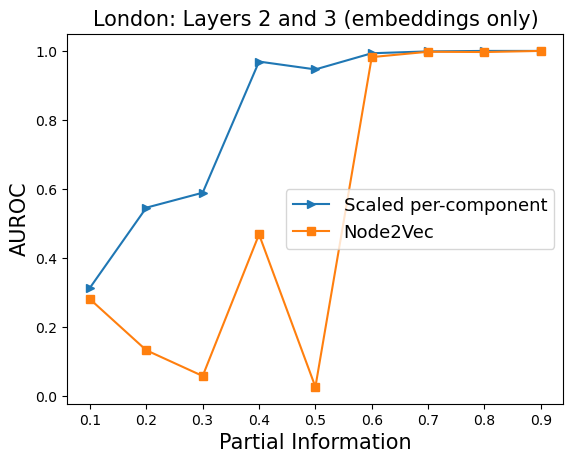

In [121]:
AUC=np.zeros(9)
ACC=np.zeros(9)
for _ in range(2):
    aucs,accs=full_model_results(layers=[2,3],)
    AUC=AUC+np.asarray(aucs)
    ACC=ACC+np.asarray(accs)
AUC=AUC/2
ACC=ACC/2

AUC_=np.zeros(9)
ACC_=np.zeros(9)
for _ in range(2):
    aucs,accs=full_model_results(layers=[2,3],per_component=False)
    AUC_=AUC_+np.asarray(aucs)
    ACC_=ACC_+np.asarray(accs)
AUC_=AUC_/2
ACC_=ACC_/2

plt.plot(np.linspace(0.1,0.9,9),AUC,'>-',label='Scaled per-component')
plt.plot(np.linspace(0.1,0.9,9),AUC_,'s-',label='Node2Vec')

# plt.ylim(0.5,1.01)
plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 2 and 3 (embeddings only)',fontsize=15)

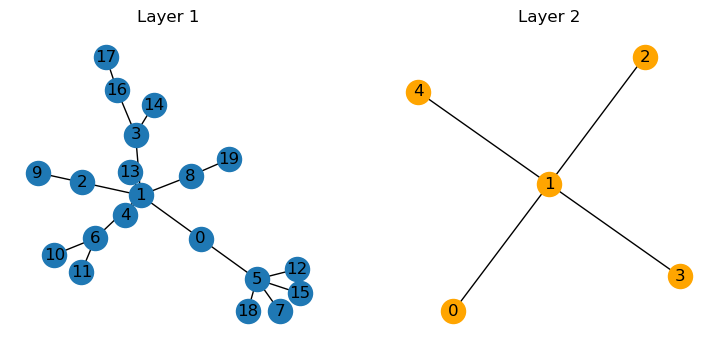

In [119]:
g1=nx.barabasi_albert_graph(20,1)
g2=nx.barabasi_albert_graph(5,1)
fig=plt.figure(figsize=(9,4))
ax1=fig.add_subplot(121)

plt.title('Layer 1')
nx.draw(g1,with_labels=True)
ax2=fig.add_subplot(122)
plt.title('Layer 2')
nx.draw(g2,node_color='orange',with_labels=True)